In [3]:
!pip install import_ipynb
!pip install ptflops
!pip install kornia
import import_ipynb
import os
import time
import copy
import argparse
import numpy as np
import torch
import torch.nn as nn
from torchvision.utils import save_image, make_grid
from ptflops import get_model_complexity_info
from utils import get_dataset, get_network, TensorDataset
from reparam_module import ReparamModule
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ptflops: filename=ptflops-0.6.9-py3-none-any.whl size=11712 sha256=9a124fbe4e1c4475b3955cdbf740209fec13f6a44fea8bfb576c26685f86df0a
  Stored in directory: /root/.cache/pip/wheels/b6/86/d5/cf62a3571b005f91cd9accefc5e10f40214538be997198afad
Successfully built ptflops
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 551 kB 4.8 MB/s 
importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from networks.ipynb
importing Jupyter notebook from reparam_module.ipynb


**Matching Training Trajectories**

Hyperparameters

In [ ]:
DATAPATH = './data'
SAVEPATH = './'
MODEL = 'ConvNet'
IMAGE_PER_CLASS = 10
EVAL_MODE = 'SS'
TRAIN_NET_EPOCH = 20
EVA_NET_EPOCH = 20
BATCH_SIZE = 1024
LR_IMG = 1000
LR_NET = 0.01
LR_LR = 1e-05
NUMBER_CLASSES = 10
ITERATIONS = 1000
NUMBER_INITIALIZATIONS = 1
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Get Trajectories

In [ ]:
def get_trajectories(dataset_name, model_name):
  channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset(dataset_name, "./data")
  trajectories = []
  for i in range(NUMBER_INITIALIZATIONS):
    model = get_network(model_name, channel, num_classes, im_size).to(DEVICE)
    trainloader = torch.utils.data.DataLoader(dst_train, batch_size=BATCH_SIZE, shuffle=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=LR_NET)
    trajectory = [[p.detach().cpu() for p in model.parameters()]]
    cee = nn.CrossEntropyLoss()
    for epoch in range(0, TRAIN_NET_EPOCH):
      model.train()
      train_loss = 0.
      for data in trainloader:
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = cee(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
      trajectory.append([p.detach().cpu() for p in model.parameters()])
      print("Epoch: {} \tTraining Cost: {:.6f}\t "
      .format(epoch, train_loss))
    trajectories.append(trajectory)
  return trajectories

In [ ]:
# load previous trajectorise reslut 
if not trajectories:
  trajectories = torch.load("./buffer.pt")

In [ ]:
def evaluate(model,valid_data):
    model.eval()
    total = 0
    correct = 0
    for data in valid_data:
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        output = model(inputs)
        output = torch.argmax(output, dim=1)
        correct += torch.sum(output == labels)
        total += BATCH_SIZE
    return correct / float(total)

def train_and_eval(model, image_syn_eval, syn_lable, dst_test):
  dst_train = TensorDataset(image_syn_eval, syn_lable)
  trainloader = torch.utils.data.DataLoader(dst_train, batch_size=BATCH_SIZE, shuffle=True)
  validLoader = torch.utils.data.DataLoader(dst_test, batch_size=BATCH_SIZE, shuffle=True)
  optimizer = torch.optim.SGD(model.parameters(), lr=LR_NET)
  cee = nn.CrossEntropyLoss()
  valid_acc = 0
  acc_save = []
  for epoch in range(TRAIN_NET_EPOCH):
    model.train()
    train_loss = 0.
    for data in trainloader:
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = cee(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    valid_acc = evaluate(model, validLoader)
    acc_save.append(valid_acc.item())
    print("Epoch: {} \tTraining Cost: {:.6f}\t "
        "Valid Acc: {}.".format(epoch, train_loss, valid_acc))
  return acc_save

In [ ]:
def train_and_evaluate(dataset_name, model_name, evluate_model_name, trajectories, randmon_init=False):
  channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset(dataset_name, DATAPATH)
  class_index = {}
  data_save = []
  for i in range(len(dst_train)):
    lable = dst_train[i][1]
    if lable in class_index:
      class_index[lable].append(i)
    else:
      class_index[lable] = [i]
  images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
  images_all = torch.cat(images_all, dim=0).to(DEVICE)
  syn_image = []
  for c in range(num_classes):
    idx_shuffle = np.random.permutation(class_index[c])[:IMAGE_PER_CLASS]
    syn_image.append(images_all[idx_shuffle])
  syn_image = torch.cat(syn_image, dim=0).to(DEVICE)
  syn_image.requires_grad = True
  if randmon_init:
    syn_image = torch.randn(size=(num_classes*IMAGE_PER_CLASS, channel, im_size[0], im_size[1]), dtype=torch.float, requires_grad=True, device=DEVICE)
  
  syn_lable = []
  for c in range(num_classes):
    syn_lable += [c for i in range(IMAGE_PER_CLASS)]
  syn_lable = torch.tensor(syn_lable,device=DEVICE)
  model = get_network(MODEL, channel, num_classes, im_size).to(DEVICE)
  model = ReparamModule(model)
  model.train()
  num_params = sum([np.prod(p.size()) for p in (model.parameters())])
  syn_lr = torch.tensor(LR_NET).to(DEVICE).requires_grad_(True)
  optimizer_img = torch.optim.SGD([syn_image], lr=LR_IMG, momentum=0.5)
  optimizer_lr = torch.optim.SGD([syn_lr], lr=LR_LR, momentum=0.5)
  optimizer_img.zero_grad()
  cee = nn.CrossEntropyLoss().to(DEVICE)
  trainloader = torch.utils.data.DataLoader(dst_train, batch_size=BATCH_SIZE, shuffle=True)
  for it in range(ITERATIONS):
    tj = trajectories[np.random.randint(0, len(trajectories))]
    start_epoch = np.random.randint(0, 4)
    starting_params = tj[start_epoch]
    target_params = tj[start_epoch + 3]
    target_params = torch.cat([p.data.to(DEVICE).reshape(-1) for p in target_params], 0)
    student_params = [torch.cat([p.data.to(DEVICE).reshape(-1) for p in starting_params], 0).requires_grad_(True)]
    starting_params = torch.cat([p.data.to(DEVICE).reshape(-1) for p in starting_params], 0)

    indices_chunks = []
    for epoch in range(20):
      if not indices_chunks:
        indices = torch.randperm(IMAGE_PER_CLASS*num_classes)
        indices_chunks = list(torch.split(indices, IMAGE_PER_CLASS))

      these_indices = indices_chunks.pop()

      image = syn_image[these_indices]
      lable = syn_lable[these_indices]
      forward_params = student_params[-1]
      output = model(image, flat_param=forward_params)
      ce_loss = cee(output, lable)
      grad = torch.autograd.grad(ce_loss, student_params[-1], create_graph=True)[0]
      student_params.append(student_params[-1] - syn_lr * grad)

    param_loss = torch.tensor(0.0).to(DEVICE)
    param_dist = torch.tensor(0.0).to(DEVICE)

    param_loss += torch.nn.functional.mse_loss(student_params[-1], target_params, reduction="sum")
    param_dist += torch.nn.functional.mse_loss(starting_params, target_params, reduction="sum")


    param_loss /= num_params
    param_dist /= num_params

    param_loss /= param_dist

    grand_loss = param_loss

    optimizer_img.zero_grad()
    optimizer_lr.zero_grad()

    grand_loss.backward()

    optimizer_img.step()
    optimizer_lr.step()
  save_name = os.path.join(SAVEPATH, 'vis_%s_%s_%s_%d.png'%(MODEL, dataset_name, randmon_init, IMAGE_PER_CLASS))
  image_syn_vis = copy.deepcopy(syn_image.detach().cpu())
  save_image(image_syn_vis, save_name, nrow=IMAGE_PER_CLASS)
  net_eval = get_network(evluate_model_name, channel, num_classes, im_size).to(DEVICE)
  image_syn_eval = copy.deepcopy(syn_image.detach())

  acc_test = train_and_eval(net_eval, image_syn_eval, syn_lable, dst_test)
  return acc_test

Here you can either load trajectories file I give or generate a new trajectories

In [ ]:
trajectories = torch.load("./MNIST_tj.pt")

In [ ]:
trajectories = torch.load("./CIFAR10_tj.pt")

In [ ]:
trajectories = get_trajectories("MNIST", "ConvNet")

In [ ]:
trajectories = get_trajectories("CIFAR10", "ConvNet")

In [ ]:
MCCT=train_and_evaluate("MNIST", "ConvNet", "ConvNet", trajectories, True)
MCCF=train_and_evaluate("MNIST", "ConvNet", "ConvNet", trajectories, False)

Epoch: 0 	Training Cost: 2.340817	 Valid Acc: 0.17265625298023224.
Epoch: 1 	Training Cost: 2.261118	 Valid Acc: 0.2588867247104645.
Epoch: 2 	Training Cost: 2.194610	 Valid Acc: 0.3797851502895355.
Epoch: 3 	Training Cost: 2.132801	 Valid Acc: 0.4751953184604645.
Epoch: 4 	Training Cost: 2.074114	 Valid Acc: 0.52587890625.
Epoch: 5 	Training Cost: 2.017833	 Valid Acc: 0.570019543170929.
Epoch: 6 	Training Cost: 1.964007	 Valid Acc: 0.6039062738418579.
Epoch: 7 	Training Cost: 1.911662	 Valid Acc: 0.6307617425918579.
Epoch: 8 	Training Cost: 1.860553	 Valid Acc: 0.654003918170929.
Epoch: 9 	Training Cost: 1.810524	 Valid Acc: 0.679003894329071.
Epoch: 10 	Training Cost: 1.761585	 Valid Acc: 0.6963867545127869.
Epoch: 11 	Training Cost: 1.713649	 Valid Acc: 0.71484375.
Epoch: 12 	Training Cost: 1.666393	 Valid Acc: 0.7293945550918579.
Epoch: 13 	Training Cost: 1.620064	 Valid Acc: 0.7442383170127869.
Epoch: 14 	Training Cost: 1.574718	 Valid Acc: 0.758105456829071.
Epoch: 15 	Training C

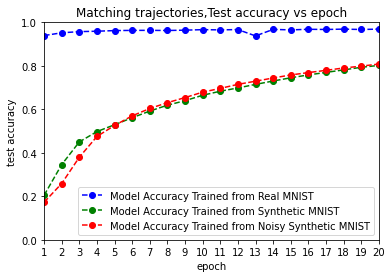

In [ ]:
val_acc_list_CIFAR_ConvNet_real=[0.45917969942092896, 0.4945312440395355, 0.548535168170929, 0.589550793170929, 0.6084961295127869, 0.612500011920929, 0.6548828482627869, 0.6435546875, 0.65087890625, 0.674023449420929, 0.6742187738418579, 0.646777331829071, 0.692187488079071, 0.699023425579071, 0.653027355670929, 0.69384765625, 0.703906238079071, 0.687304675579071, 0.7125000357627869, 0.7110351920127869]
val_acc_list_MNIST_ConvNet_real=[0.9393554925918579, 0.951953113079071, 0.957324206829071, 0.959277331829071, 0.962109386920929, 0.963085949420929, 0.9632812738418579, 0.962597668170929, 0.964160144329071, 0.9664062857627869, 0.9654297232627869, 0.966796875, 0.9375976920127869, 0.9676758050918579, 0.96533203125, 0.9681640863418579, 0.96728515625, 0.968945324420929, 0.9671875238418579, 0.968945324420929]

x_axis=list(range(1,TRAIN_NET_EPOCH+1))
plt.plot(x_axis,val_acc_list_MNIST_ConvNet_real,'--bo', label='Model Accuracy Trained from Real MNIST')
plt.plot(x_axis,MCCF,'--go', label='Model Accuracy Trained from Synthetic MNIST')
plt.plot(x_axis,MCCT,'--ro', label='Model Accuracy Trained from Noisy Synthetic MNIST')
plt.xticks(range(1,TRAIN_NET_EPOCH+1))
plt.legend()
plt.xlim((1,TRAIN_NET_EPOCH))
plt.ylim((0,1))
plt.title("Matching trajectories,Test accuracy vs epoch")
plt.ylabel("test accuracy")
plt.xlabel("epoch")
plt.savefig("mnist_compare")
plt.show()

In [ ]:
CCCT=train_and_evaluate("CIFAR10", "ConvNet", "ConvNet", trajectories, True)
CCCF=train_and_evaluate("CIFAR10", "ConvNet", "ConvNet", trajectories, False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch: 0 	Training Cost: 2.364705	 Valid Acc: 0.10615234822034836.
Epoch: 1 	Training Cost: 2.290199	 Valid Acc: 0.11806640774011612.
Epoch: 2 	Training Cost: 2.229358	 Valid Acc: 0.12871094048023224.
Epoch: 3 	Training Cost: 2.174900	 Valid Acc: 0.13916015625.
Epoch: 4 	Training Cost: 2.123770	 Valid Acc: 0.14921875298023224.
Epoch: 5 	Training Cost: 2.074607	 Valid Acc: 0.16044922173023224.
Epoch: 6 	Training Cost: 2.026788	 Valid Acc: 0.17041015625.
Epoch: 7 	Training Cost: 1.980136	 Valid Acc: 0.18173828721046448.
Epoch: 8 	Training Cost: 1.934586	 Valid Acc: 0.19160155951976776.
Epoch: 9 	Training Cost: 1.889997	 Valid Acc: 0.20351563394069672.
Epoch: 10 	Training Cost: 1.846418	 Valid Acc: 0.21376954019069672.
Epoch: 11 	Training Cost: 1.803829	 Valid Acc: 0.22216796875.
Epoch: 12 	Training Cost: 1.762177	 Valid Acc: 0.23076172173023224.
Epoch: 13 	Training Cost: 1.721284	 Valid Acc: 0.239843

Distribution matching

In [5]:
DATAPATH = './data'
SAVEPATH = './'
MODEL = 'ConvNet'
IMAGE_PER_CLASS = 10
EVAL_MODE = 'SS'
TRAIN_NET_EPOCH = 20
BATCH_SIZE = 20
LR_IMG = 0.1
LR_NET = 0.01
NUMBER_CLASSES = 10
ITERATIONS = 10
NUMBER_INITIALIZATIONS = 100
NUMBER_STEP_OPT = 20
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:


def train_and_eval(model, image_syn_eval, syn_lable, dst_test):
  dst_train = TensorDataset(image_syn_eval, syn_lable)
  trainloader = torch.utils.data.DataLoader(dst_train, batch_size=BATCH_SIZE, shuffle=True)
  validLoader = torch.utils.data.DataLoader(dst_test, batch_size=BATCH_SIZE, shuffle=True)
  optimizer = torch.optim.SGD(model.parameters(), lr=LR_NET)
  cee = nn.CrossEntropyLoss()
  valid_accs = []
  for epoch in range(TRAIN_NET_EPOCH):
    model.train()
    train_loss = 0.

    for data in trainloader:
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = cee(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    valid_acc = evaluate(model, validLoader)
    valid_accs.append(valid_acc)
    print("Epoch: {} \tTraining Cost: {:.6f}\t "
        "Valid Acc: {}.".format(epoch, train_loss, valid_acc))
  return valid_accs

def evaluate(model,valid_data):
    model.eval()
    total = 0
    correct = 0
    for data in valid_data:
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        output = model(inputs)
        output = torch.argmax(output, dim=1)
        correct += torch.sum(output == labels)
        total += BATCH_SIZE
    return correct / float(total)

def train_model(model, image_syn_eval, syn_lable, epochs):
  dst_train = TensorDataset(image_syn_eval, syn_lable)
  trainloader = torch.utils.data.DataLoader(dst_train, batch_size=BATCH_SIZE, shuffle=True)
  optimizer = torch.optim.SGD(model.parameters(), lr=LR_NET)
  cee = nn.CrossEntropyLoss()
  for e in range(epochs):
    model.train()
    train_loss = 0.

    for data in trainloader:
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = cee(outputs, labels)
        loss.backward()
        optimizer.step()

def loss_function(img_real, img_syn):
  return torch.sum((torch.mean(img_real, dim=0) - torch.mean(img_syn, dim=0))**2)

def train_synthetic_data(model, img_all, syn_image, num_class, iterations, class_index):
  optimizer_img = torch.optim.SGD([syn_image, ], lr=LR_IMG)
  total_loss = 0 
  for it in range(ITERATIONS):
    loss = torch.tensor(0.0).to(DEVICE)
    
    for c in range(num_class):
      strat_index = c*IMAGE_PER_CLASS
      img_real = img_all[np.random.permutation(class_index[c])[:IMAGE_PER_CLASS]]
      image_syn = syn_image[strat_index: strat_index + IMAGE_PER_CLASS]
      output_syn = model.embed(image_syn)
      output_real = model.embed(img_real).detach()
      loss += loss_function(output_syn, output_real)
    total_loss += loss
    optimizer_img.zero_grad()
    loss.backward()
    optimizer_img.step()
  return total_loss/iterations

def condensed_images_and_evaluate(dataset_name, model_name, eval_mode_name, randmon_init=False):
  channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset(dataset_name, DATAPATH)
  class_index = {}
  data_save = []
  for i in range(len(dst_train)):
    lable = dst_train[i][1]
    if lable in class_index:
      class_index[lable].append(i)
    else:
      class_index[lable] = [i]
  images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
  images_all = torch.cat(images_all, dim=0).to(DEVICE)
  syn_image = []
  for c in range(num_classes):
    idx_shuffle = np.random.permutation(class_index[c])[:IMAGE_PER_CLASS]
    syn_image.append(images_all[idx_shuffle])
  syn_image = torch.cat(syn_image, dim=0).to(DEVICE)
  syn_image.requires_grad = True
  syn_lable = []
  for c in range(num_classes):
    syn_lable += [c for i in range(IMAGE_PER_CLASS)]
  syn_lable = torch.tensor(syn_lable,device=DEVICE)
  if randmon_init:
    syn_image = torch.randn(size=(num_classes*IMAGE_PER_CLASS, channel, im_size[0], im_size[1]), dtype=torch.float, requires_grad=True, device=DEVICE)
  for exp in range(NUMBER_INITIALIZATIONS):
    model = get_network(model_name, channel, num_classes, im_size).to(DEVICE)
    model.train()
    train_synthetic_data(model, images_all, syn_image, num_classes, ITERATIONS, class_index)
      
  random = "Gaussian noise" if randmon_init else "real training images"
  save_name = os.path.join(SAVEPATH, 'vis_%s_%s_%s_%d.png'%(model_name, dataset_name, random, IMAGE_PER_CLASS))
  image_syn_vis = copy.deepcopy(syn_image.detach().cpu())
  save_image(image_syn_vis, save_name, nrow=IMAGE_PER_CLASS)
  make_grid(image_syn_vis, nrow=IMAGE_PER_CLASS)
  net_eval = get_network(eval_mode_name, channel, num_classes, im_size).to(DEVICE)
  image_syn_eval = copy.deepcopy(syn_image.detach())

  acc_test = train_and_eval(net_eval, image_syn_eval, syn_lable, dst_test)

In [10]:
condensed_images_and_evaluate("MNIST", "ConvNet", "ConvNet", True)

Epoch: 0 	Training Cost: 12.079541	 Valid Acc: 0.2418999969959259.
Epoch: 1 	Training Cost: 10.889627	 Valid Acc: 0.27789998054504395.
Epoch: 2 	Training Cost: 10.006436	 Valid Acc: 0.5163999795913696.
Epoch: 3 	Training Cost: 9.107571	 Valid Acc: 0.5516999959945679.
Epoch: 4 	Training Cost: 8.624026	 Valid Acc: 0.46769997477531433.
Epoch: 5 	Training Cost: 8.121030	 Valid Acc: 0.517300009727478.
Epoch: 6 	Training Cost: 7.152822	 Valid Acc: 0.5209999680519104.
Epoch: 7 	Training Cost: 6.610772	 Valid Acc: 0.6782000064849854.
Epoch: 8 	Training Cost: 6.019576	 Valid Acc: 0.6832000017166138.
Epoch: 9 	Training Cost: 5.907747	 Valid Acc: 0.6588000059127808.
Epoch: 10 	Training Cost: 5.088057	 Valid Acc: 0.699400007724762.
Epoch: 11 	Training Cost: 5.088383	 Valid Acc: 0.7249999642372131.
Epoch: 12 	Training Cost: 4.472686	 Valid Acc: 0.7033999562263489.
Epoch: 13 	Training Cost: 4.085270	 Valid Acc: 0.7303000092506409.
Epoch: 14 	Training Cost: 3.774598	 Valid Acc: 0.7078999876976013.
Ep

In [11]:
condensed_images_and_evaluate("MNIST", "ConvNet", "ConvNet")

Epoch: 0 	Training Cost: 11.453368	 Valid Acc: 0.26499998569488525.
Epoch: 1 	Training Cost: 9.340059	 Valid Acc: 0.48009997606277466.
Epoch: 2 	Training Cost: 8.107704	 Valid Acc: 0.5532999634742737.
Epoch: 3 	Training Cost: 7.070531	 Valid Acc: 0.5722000002861023.
Epoch: 4 	Training Cost: 6.274439	 Valid Acc: 0.6864999532699585.
Epoch: 5 	Training Cost: 5.391182	 Valid Acc: 0.7378999590873718.
Epoch: 6 	Training Cost: 4.833286	 Valid Acc: 0.8086000084877014.
Epoch: 7 	Training Cost: 4.220173	 Valid Acc: 0.8337999582290649.
Epoch: 8 	Training Cost: 3.732135	 Valid Acc: 0.8295999765396118.
Epoch: 9 	Training Cost: 3.429998	 Valid Acc: 0.8264999985694885.
Epoch: 10 	Training Cost: 3.041802	 Valid Acc: 0.8628000020980835.
Epoch: 11 	Training Cost: 2.687205	 Valid Acc: 0.8623999953269958.
Epoch: 12 	Training Cost: 2.570845	 Valid Acc: 0.8834999799728394.
Epoch: 13 	Training Cost: 2.196738	 Valid Acc: 0.8750999569892883.
Epoch: 14 	Training Cost: 2.005292	 Valid Acc: 0.8727999925613403.
Ep